In [1]:
from dataset import DiscotubeDataset
import matplotlib.pyplot as plt
import joblib

In [2]:
dt_dataset = DiscotubeDataset(pickle_file='../out/gt_20k.pk',
                              root='/scratch/palonso/data/discotube-specs/',
                              sampling_strategy='random_patch')

In [3]:
encoder = joblib.load('../out/encoder_20k.joblib')

idx:  0 mel shape:  (1, 64, 96) lables shapeshape:  (200,)
[('Classical', 'Folk, World, & Country', 'Pop', 'Stage & Screen')]


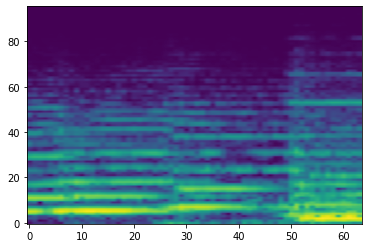

idx:  1 mel shape:  (1, 64, 96) lables shapeshape:  (200,)
[('Electronic', 'Noise')]


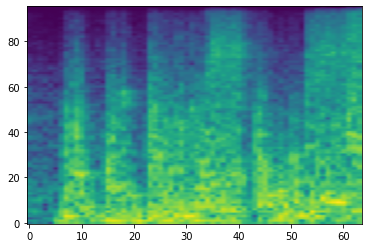

idx:  2 mel shape:  (1, 64, 96) lables shapeshape:  (200,)
[('Dubstep', 'Electro', 'Electronic', 'House')]


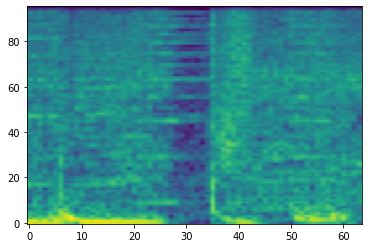

idx:  3 mel shape:  (1, 64, 96) lables shapeshape:  (200,)
[('Electronic', 'House', 'Progressive House', 'Tech House', 'Techno', 'Trance', 'Tribal', 'Tribal House')]


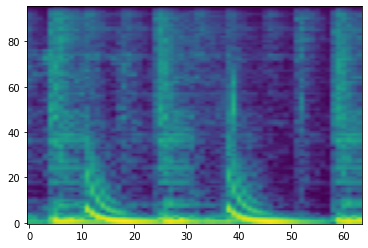

In [4]:
for i in range(len(dt_dataset)):
    sample = dt_dataset[i]

    print('idx: ', i, 'mel shape: ', sample['melspectrogram'].shape, 'lables shapeshape: ', sample['tags'].shape)
    print(encoder.inverse_transform(sample['tags'].reshape(1, -1)))
    
    plt.imshow(sample['melspectrogram'].T.astype('float32'), aspect='auto', origin='lower')
    plt.show()

    if i == 3:
        break

In [5]:
from datetime import datetime
import argparse
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.distributed as dist

In [16]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=200):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7488, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [17]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('-n', '--nodes', default=1, type=int, metavar='N')
    parser.add_argument('-g', '--gpus', default=1, type=int,
                        help='number of gpus per node')
    parser.add_argument('-nr', '--nr', default=0, type=int,
                        help='ranking within the nodes')
    parser.add_argument('--epochs', default=2, type=int, metavar='N',
                        help='number of total epochs to run')
    args, unknown = parser.parse_known_args()
    train(0, args)


In [18]:
def train(gpu, args):
    torch.manual_seed(0)
    model = ConvNet()
    torch.cuda.set_device(gpu)
    model.cuda(gpu)
    batch_size = 100
    # define loss function (criterion) and optimizer
    criterion = nn.MultiLabelMarginLoss().cuda(gpu)
    optimizer = torch.optim.SGD(model.parameters(), 1e-4)
    # Data loading code
    train_dataset = DiscotubeDataset(pickle_file='../out/gt_20k.pk',
                                     root='/scratch/palonso/data/discotube-specs/',
                                     sampling_strategy='random_patch')
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=0,
                                               pin_memory=True)

    start = datetime.now()
    total_step = len(train_loader)
    for epoch in range(args.epochs):
        for i, sample in enumerate(train_loader):
            images = sample['melspectrogram']
            labels = sample['tags']
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0 and gpu == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch + 1, 
                    args.epochs, 
                    i + 1, 
                    total_step,
                    loss.item())
                   )
    if gpu == 0:
        print("Training complete in: " + str(datetime.now() - start))

In [19]:
main()

Epoch [1/2], Step [100/200], Loss: 0.0003
Epoch [1/2], Step [200/200], Loss: 0.0001
Epoch [2/2], Step [100/200], Loss: 0.0003
Epoch [2/2], Step [200/200], Loss: 0.0002
Training complete in: 0:00:24.493953


In [20]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('-n', '--nodes', default=1, type=int, metavar='N')
    parser.add_argument('-g', '--gpus', default=1, type=int,
                        help='number of gpus per node')
    parser.add_argument('-nr', '--nr', default=0, type=int,
                        help='ranking within the nodes')
    parser.add_argument('--epochs', default=2, type=int, metavar='N',
                        help='number of total epochs to run')
    args, unknown = parser.parse_known_args()
    
    args.world_size = args.gpus * args.nodes
    os.environ['MASTER_ADDR'] = '10.55.0.129'
    os.environ['MASTER_PORT'] = '8888'
    mp.spawn(train, nprocs=args.gpus, args=(args,)) 
    train(0, args)